# Learning about Survival Analysis

## Survival Analysis with LightGBM plus Poisson Regression

Estimate Probability Density Functions applying a Survival approach

Survival Analysis is often applied to address questions such as *"how long would it be before a particular event occurs?*. **Events** and **Time** are critical variables of this kind approach. The events are extremes situation that may occur in every moment: classical examples are churns, deaths, faults and so on. The definition of time is simple but a little bit abstract. We consider time as durations; in this sense, it's obvious that not all the "extreme events" have occured yet. We can't view all the life history due to some external circumstances, this implies considering durations as relative; starts may occur at different times. 

Traditionally survival analysis was developed to measure lifespans of individuals. The analysis can be further applied to not just traditional births and deaths, but durations and more ... It's amazing how can we approach a classification/regression problem with survival modeling. All we need to define is the Events and Time. 

In this post, we develop a solution to predict *how daily bike rentals are registered under some kind of temporal and weather conditions.* The task is in the format of a regresison problem, where we have to predict a count, this can also remind us a Poisson Regression problem where we have to model a discrete variable. Our added value is to change the point of view switching to a survival approach, considering that Time is a number of rentals progressively "reach so far" and the Event is the final count registered at the end of the day. To model this phenomena, we'll use an adapted LightGBM estimator

### From regression to survival

When time and event are defined (we have respectively observations and targets) we have to reason about how we can reach our final scope: estimate a **Survival Function.**

All start quantifying Time; it is a non-negative continuous random variable which distribution is characterized by the Probability Density Function (PDF) or the Cumulative Distribution Function (CDF)

The survival function (S) is a function of the time which defines the probability the death event has not occured yet a time t, or equivalently, give us the proportion of the population with the time to event value more than t. Mathematically, it's 1-CDF. The **Hazard function** (H) is the rate at which the event is taking place. Given a fixed time interval, it is a measure of risk, the greater the hazard the greater the risk of failure. Mathemically, it's -log(S).

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*JgLYV5XvZA9hO20JyILbkQ.png)

There are various approaches to fit survival models. In detail, we are interested in the so-called semi-parametric approach, where we try to learn the hazard function with a very elegant and straightforward trick: we assume to may subdivide time into reasonably small intervals, i.e. we are considering our baseline hazard constant in each interval. In this format, a piece-wise proportional hazards model is equivalent to a certain Poisson regression model. The fact that Survival function can be derived from the Hazard function and vice versa, is particularly useful because permits us to switch easily our target according to our interests.


### The data

The dataset we utilize is related to the two-year historical data corresponding to years 2011 and 2012 from the Capital Bikeshare system of Washington D.C, which is publicly available in daily and hourly format. At the moment we consider the daily data focusing our attention in predicting the count of casual users reached at the end of the day. Various predictors are available to produce forecasts like temporal or weather regressors.

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import lightgbm as lgb

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


### READ DATA ###

df = pd.read_csv('day.csv')
df['dteday'] = pd.to_datetime(df.dteday)

print(df.shape)
df.head()

(731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
### CASUAL COUNT STATISTICS ###

df.groupby('yr')['casual'].agg(['min','max','mean'])

,min,max,mean
yr,,,
0,9,3065,677.402740
1,2,3410,1018.483607


In [5]:
### DEFINE CRPS METRIC ###

def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true-y_pred)**2).sum(axis=1).sum(axis=0) / (y_true.shape[1]*y_true.shape[0])

In [6]:
### DEFINE REGRESSOR COLUMNS ###

columns = [c for c in df.columns if c not in ['instant','dteday','casual','registered','cnt']]
print(columns)

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [7]:
### TRAIN, VALIDATION, TEST SPLIT ###

X_train = df[df.dteday < datetime(year=2012, month=1, day=1)].copy()
train_date = X_train.dteday.values

X_val = df[(df.dteday >= datetime(year=2012, month=1, day=1))&(df.dteday < datetime(year=2012, month=5, day=1))].copy()
val_date = X_val.dteday.values

X_test = df[(df.dteday >= datetime(year=2012, month=5, day=1))].copy()
test_date = X_test.dteday.values

print(X_train.shape, X_val.shape, X_test.shape)
X_train.head()

(365, 16) (121, 16) (245, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


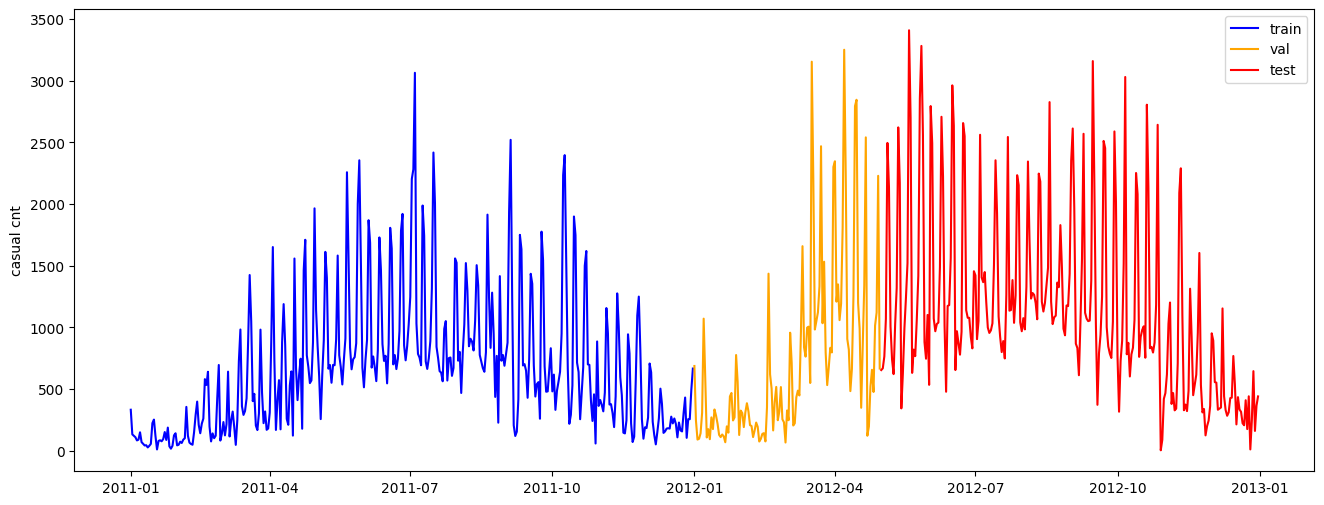

In [8]:
### CASUAL COUNT PLOT ###

plt.figure(figsize=(16,6))

plt.plot(train_date, X_train.casual, label='train', color='blue')
plt.plot(val_date, X_val.casual, label='val', color='orange')
plt.plot(test_date, X_test.casual, label='test', color='red')
plt.ylabel('casual cnt')
plt.legend()

Remember that we define our Time variable as the rentals “reach so far” and the Event as the final count registered, so a good starting point consists of plotting CDFs of Time.

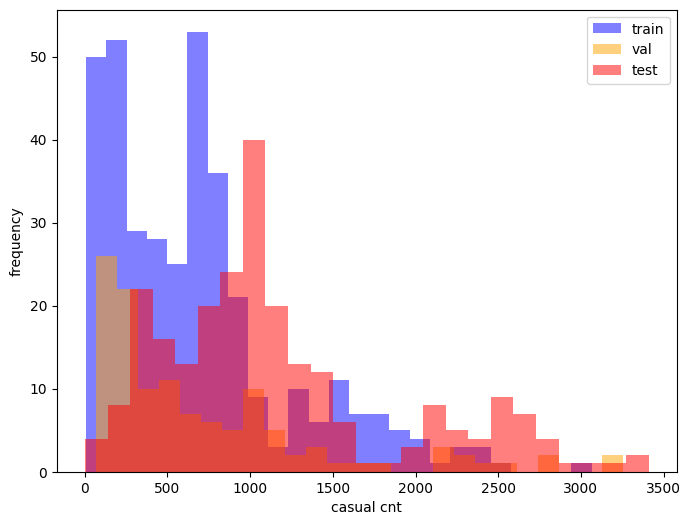

In [9]:
### CASUAL COUNT DISTRIBUTION ###

plt.figure(figsize=(8,6))

plt.hist(X_train.casual, label='train', bins=25, alpha=0.5, color='blue')
plt.hist(X_val.casual, label='val', bins=25, alpha=0.5, color='orange')
plt.hist(X_test.casual, label='test', bins=25, alpha=0.5, color='red')
plt.ylabel('frequency'); plt.xlabel('casual cnt')
plt.legend()

In [10]:
### DEFINE MAX PLAUSIBLE CASUAL COUNT ###
max_count = 4000

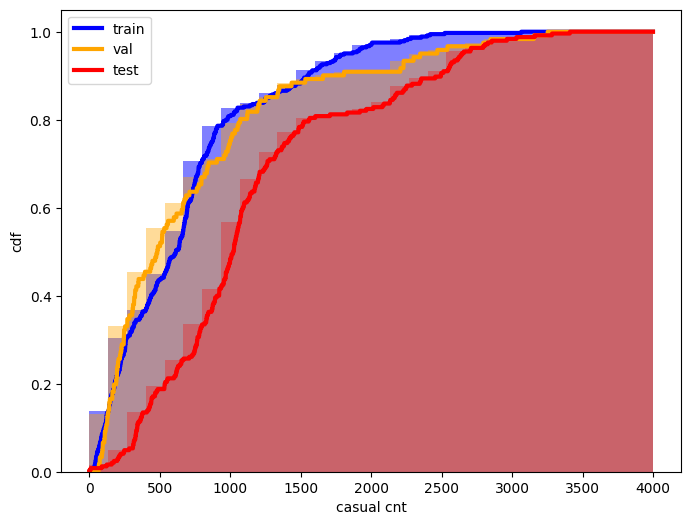

In [11]:
### CDF CASUAL COUNT PLOT ###

plt.figure(figsize=(8,6))

plt.hist(X_train.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.5, color='blue')
cdf = np.histogram(X_train.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='blue', linewidth=3, label='train')

plt.hist(X_val.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.4, color='orange')
cdf = np.histogram(X_val.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='orange', linewidth=3, label='val')

plt.hist(X_test.casual, range=(0,max_count), bins=30, 
         cumulative=True, density=True, alpha=0.3, color='red')
cdf = np.histogram(X_test.casual, range=(0,max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='red', linewidth=3, label='test')

plt.ylabel('cdf'); plt.xlabel('casual cnt')
plt.legend()

With a fixed established amount of max count reachable (4000), it’s obvious that the CDFs of our train-test partition is quite different.

### Learning LightGBM with Poisson Regression

Learning a Hazard function applying the *semi-parametric exponential approach* is quite easy with a LGBM regressor. This is possible (as introduced above) because the negative log-likelihood of the survival problem is 1-to-1 mapped with the negative log-likelihood of a Poisson Regression, which is by default initialized in the LGBM library.

All we need to do is arrange our data for this purpose. Particularly, the dataset has first to be extended: each line is duplicated in multiple lines from 0 to causal count registered which is our death Event. Then two new columns are generated:

- counts so far: taking values from 0 to causal count registered;
- stop: being equal to 0 everywhere except at lines where count so far = causal count



In [13]:
### EXPAND TRAIN DATA ###

X_train['count_so_far'] = X_train.apply(lambda x: np.arange(x.casual), axis=1)
X_train['stop'] = X_train.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_train = X_train.apply(pd.Series.explode)

X_train['count_so_far'] = X_train.count_so_far.astype(int)
X_train['stop'] = X_train.stop.astype(int)

y_train = X_train['stop']
X_train = X_train[columns+['count_so_far']]

print(X_train.shape)

(247252, 12)


In [15]:
### EXPAND VALID DATA ###

X_val['count_so_far'] = X_val.apply(lambda x: np.arange(x.casual), axis=1)
X_val['stop'] = X_val.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_val = X_val.apply(pd.Series.explode)

X_val['count_so_far'] = X_val.count_so_far.astype(int)
X_val['stop'] = X_val.stop.astype(int)

y_val = X_val['stop']
X_val = X_val[columns+['count_so_far']]

print(X_val.shape)

(87764, 12)


In [16]:
### EXPAND VALID DATA FOR PREDICTION ###

X_val_surv = df[(df.dteday >= datetime(year=2012, month=1, day=1))&(df.dteday < datetime(year=2012, month=5, day=1))].copy()

X_val_surv['count_so_far'] = X_val_surv.apply(lambda x: np.arange(max_count), axis=1)
X_val_surv['stop'] = X_val_surv.apply(lambda x:np.append(np.zeros(x.casual), np.ones(max_count-x.casual)), axis=1)
X_val_surv = X_val_surv.apply(pd.Series.explode)

X_val_surv['count_so_far'] = X_val_surv.count_so_far.astype(int)
X_val_surv['stop'] = X_val_surv.stop.astype(int)

y_val_surv = X_val_surv['stop']
X_val_surv = X_val_surv[columns+['count_so_far']]

print(X_val_surv.shape)

(484000, 12)


In [17]:
### EXPAND TEST DATA ###

X_test['count_so_far'] = X_test.apply(lambda x: np.arange(x.casual), axis=1)
X_test['stop'] = X_test.apply(lambda x: np.append(np.zeros(x.casual-1), 1), axis=1)
X_test = X_test.apply(pd.Series.explode)

X_test['count_so_far'] = X_test.count_so_far.astype(int)
X_test['stop'] = X_test.stop.astype(int)

y_test = X_test['stop']
X_test = X_test[columns+['count_so_far']]

print(X_test.shape)

(285001, 12)


In [18]:
### EXPAND TEST DATA FOR PREDICTION ###

X_test_surv = df[(df.dteday >= datetime(year=2012, month=5, day=1))].copy()

X_test_surv['count_so_far'] = X_test_surv.apply(lambda x: np.arange(max_count), axis=1)
X_test_surv['stop'] = X_test_surv.apply(lambda x: np.append(np.zeros(x.casual), np.ones(max_count-x.casual)), axis=1)
X_test_surv = X_test_surv.apply(pd.Series.explode)

X_test_surv['count_so_far'] = X_test_surv.count_so_far.astype(int)
X_test_surv['stop'] = X_test_surv.stop.astype(int)

y_test_surv = X_test_surv['stop']
X_test_surv = X_test_surv[columns+['count_so_far']]

print(X_test_surv.shape)

(980000, 12)


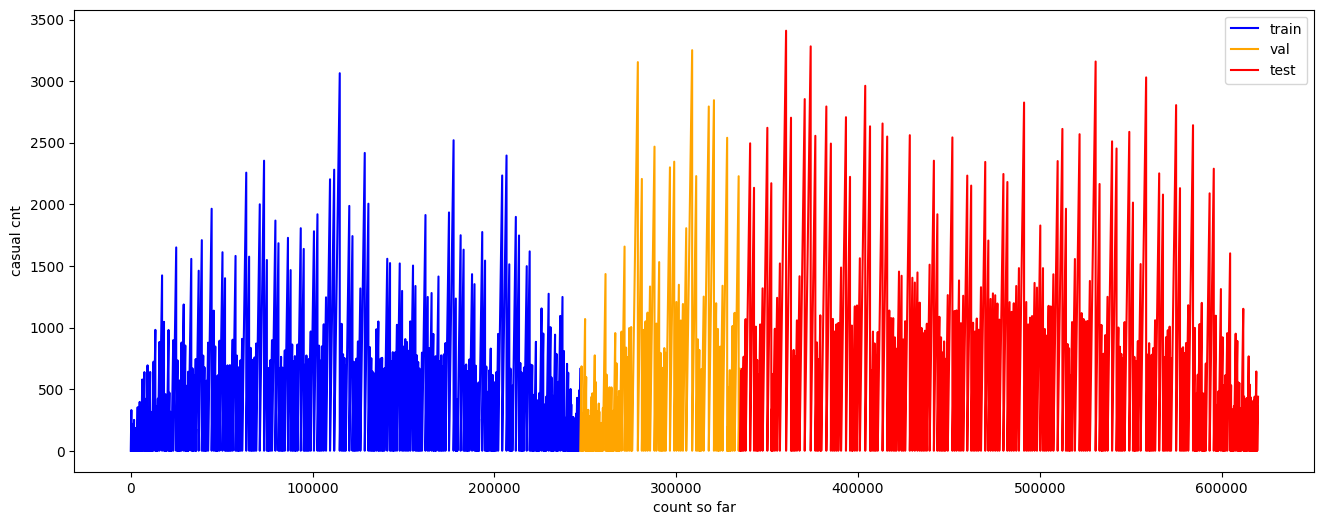

In [19]:
### PLOT COUNT SO FAR VARIABLE ### 

plt.figure(figsize=(16,6))

plt.plot(range(len(X_train)), X_train.count_so_far, label='train', color='blue')
plt.plot(range(len(X_train),len(X_val)+len(X_train)), X_val.count_so_far, label='val', color='orange')
plt.plot(range(len(X_val)+len(X_train),len(X_val)+len(X_train)+len(X_test)), X_test.count_so_far, label='test', color='red')
plt.ylabel('casual cnt'); plt.xlabel('count so far')
plt.legend(loc='upper right')

/tmp/ipykernel_24756/1381529142.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  csf = plt.plot(range(6000,15000), X_train.count_so_far[6000:15000], color='blue')
/tmp/ipykernel_24756/1381529142.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  scr = plt.plot(range(6000,15000), y_train[6000:15000], color='magenta', alpha=0.6)


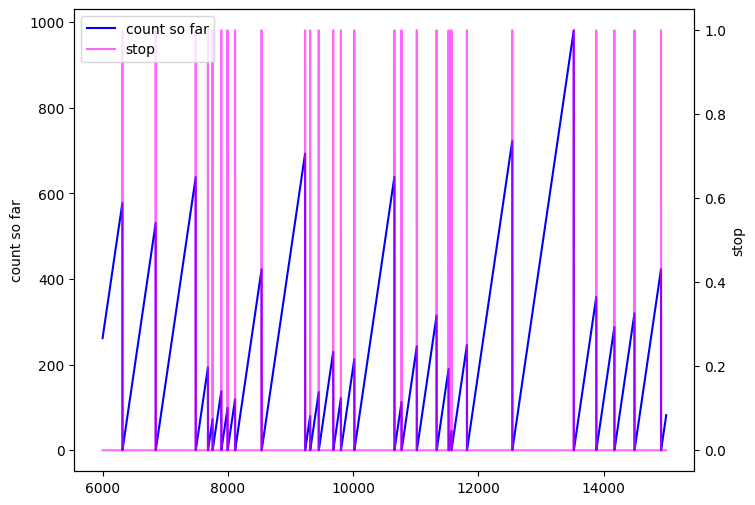

In [20]:
### PLOT COUNT SO FAR VARIABLE ZOOM ### 

plt.figure(figsize=(8,6))

csf = plt.plot(range(6000,15000), X_train.count_so_far[6000:15000], color='blue')
plt.ylabel('count so far')
plt.twinx()
scr = plt.plot(range(6000,15000), y_train[6000:15000], color='magenta', alpha=0.6)
plt.ylabel('stop')
plt.legend(csf+scr, ['count so far', 'stop'], loc='upper left')

With our expanded dataset we are ready to start training. The fit is computed as always: our target is represented by score (a 0–1 variable) and our regressors are all the available external variables plus count so far, previously generated by ourselves. All the magic is made by our assumptions and by the Poisson loss. In the phase of prediction, we have to manipulate our test data as made before, expanding the input data with the creation of the count so far variable (score is unknown). To have a uniform shape of our survival functions and facilitate score evaluation, it’s a good practice to expand the count so far together with other predictors, until a prefixed limit, 4000 for us. Remember also that the LGBM predicts the Hazard function, to obtain the corresponding Survival function we have to operate this simple post-process transformation: 1-exp(cumsum(H)).

In [23]:
params = {
         'objective':'poisson',
         'num_leaves':30, 
         'learning_rate': 0.001,
         'feature_fraction': 0.8,
         'bagging_fraction': 0.9,
         'bagging_seed': 33,
         'poisson_max_delta_step': 0.8,
         'metric': 'poisson'
         }

### FIT LGBM WITH POISSON LOSS ### 

trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, trn_data, num_boost_round=1000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=50, early_stopping_rounds=150)

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 247252, number of used features: 11
[LightGBM] [Info] Start training from score -6.518266
Training until validation scores don't improve for 150 rounds
[50]	training's poisson: 0.0109371	valid_1's poisson: 0.0103395
[100]	training's poisson: 0.0107962	valid_1's poisson: 0.0102309
[150]	training's poisson: 0.0106887	valid_1's poisson: 0.0101797
[200]	training's poisson: 0.0105766	valid_1's poisson: 0.0101594
[250]	training's poisson: 0.0104729	valid_1's poisson: 0.0101736
[300]	training's poisson: 0.0103815	valid_1's poisson: 0.0102137
Early stopping, best iteration is:
[187]	training's poisson: 0.0106026	valid_1's poisson: 0.0101573


In [24]:
### PREDICT HAZARD FUNCTION ON VALIDATION DATA AND TRANSFORM TO SURVIVAL ###

p_val_hz = model.predict(X_val_surv).reshape(-1,max_count)
p_val = 1-np.exp(-np.cumsum(p_val_hz, axis=1))
p_val.shape

(121, 4000)

In [25]:
p_val

array([[0.00148104, 0.00295989, 0.00443654, ..., 0.99911351, 0.99911502,
        0.99911653],
       [0.00148086, 0.00295952, 0.004436  , ..., 0.99929704, 0.99929828,
        0.99929952],
       [0.00180538, 0.00360749, 0.00540635, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.00144912, 0.00289615, 0.00434108, ..., 0.99754708, 0.99755083,
        0.99755458],
       [0.00139296, 0.00278398, 0.00417307, ..., 0.99715081, 0.99715508,
        0.99715934],
       [0.00140897, 0.00281595, 0.00422095, ..., 0.99998882, 0.99998886,
        0.99998889]])

In [26]:
### GET TRUE CDF ON VALIDATION DATA ###

t_val = y_val_surv.values.reshape(-1,max_count)
t_val.shape

(121, 4000)

In [27]:
t_val

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [28]:
### CRPS ON VALIDATION DATA ###

crps(t_val, p_val)

0.17425293919055515

In [29]:
### CRPS ON VALIDATION DATA WITH BASELINE MODEL ###

crps(t_val, np.repeat(cdf, len(t_val)).reshape(-1,max_count))

0.17963328860908506

In [30]:
### PREDICT HAZARD FUNCTION ON TEST DATA AND TRANSFORM TO SURVIVAL ###

p_test_hz = model.predict(X_test_surv).reshape(-1,max_count)
p_test = 1-np.exp(-np.cumsum(p_test_hz, axis=1))
p_test.shape

(245, 4000)

In [31]:
### GET TRUE CDF ON TEST DATA ###

t_test = y_test_surv.values.reshape(-1,max_count)
t_test.shape

(245, 4000)

In [32]:
### CRPS ON TEST DATA ###

crps(t_test, p_test)

0.2836082945068059

In [33]:
### CRPS ON TEST DATA WITH BASELINE MODEL ###

crps(t_test, np.repeat(cdf, len(t_test)).reshape(-1,max_count))

0.2892390593715204

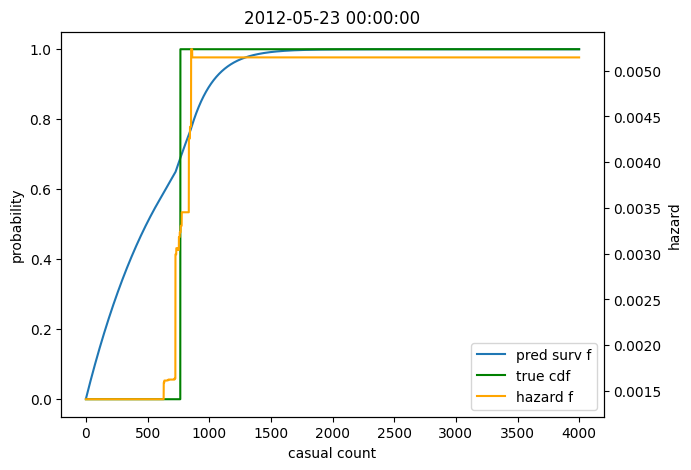

In [34]:
### PLOT PREDICTIONS ###
_id = 22

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.title(pd.to_datetime(test_date[_id]))
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')

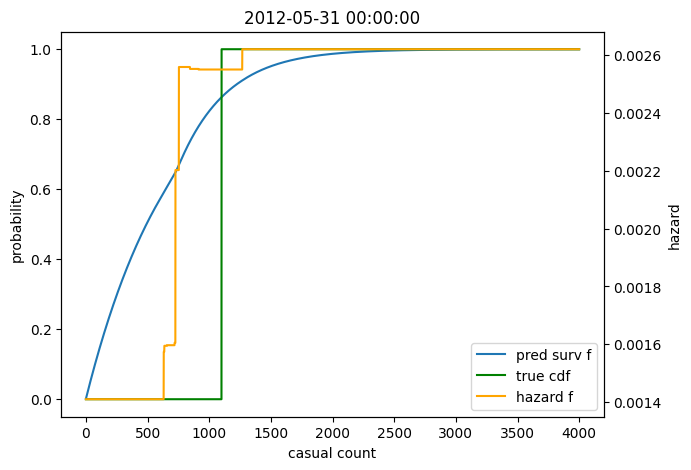

In [35]:
### PLOT PREDICTIONS ###
_id = 30

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.title(pd.to_datetime(test_date[_id]))
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')

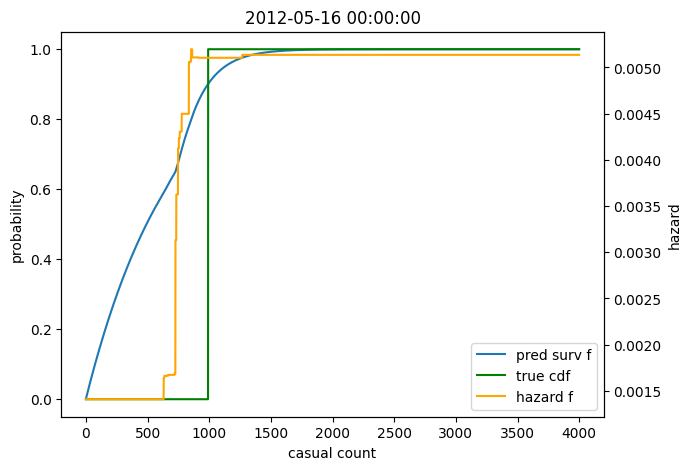

In [36]:
### PLOT PREDICTIONS ###
_id = 15

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.title(pd.to_datetime(test_date[_id]))
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')

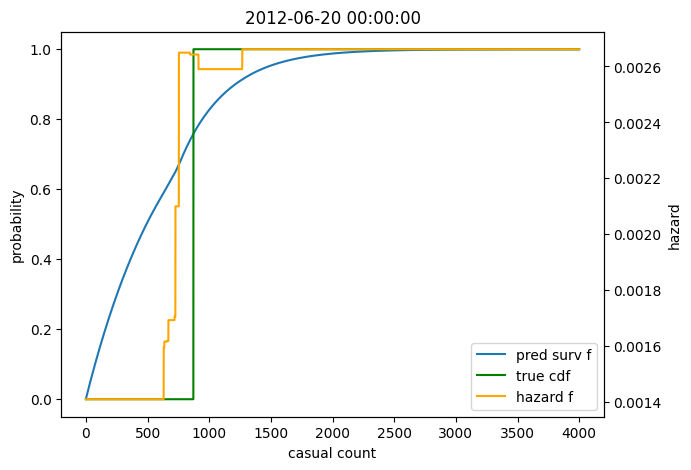

In [37]:
### PLOT PREDICTIONS ###
_id = 50

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability'); plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.title(pd.to_datetime(test_date[_id]))
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')

As you can see, the predicted Survival function, derived from the Hazard function, tries to replicate the true CDF built from the total count of the casual users at the end of the day. We are predicting a cumulative probability distribution for the total users count. In other words, each value we predict indicates the probability that at the end of the day the final count is less or equal that number.

The evaluation of our results is made with a standard score for this kind of task. Continuous Ranked Probability Score (CRPS) generalizes the MAE to the case of probabilistic forecasts.

$$ CRPS = {1 \over 4000N} \sum_{m=1}^{N}\sum_{n=0}^{3999} (P(y<=n)-H(n-V_{m}))^2 $$

The CPRS is one of the most widely used accuracy metrics where probabilistic forecasts are involved. It requires to evaluate the whole probability function involved, so the estimation of the whole survival curve for each daily sample is needed. In the end, we can reach 0.283 CRPS on the test, which is better than a simple model based on a dummy estimation of the test survival functions with the CDF derived from the train (0.291 CRPS).

## Rethinking Survival Analysis: How to make your model Produce Survival Curves

**Time to Event Forecasting with Simple ML Approaches**

In data-driven companies, time-to-event applications assume a crucial role in decision-making (also more than we can imagine). **With time-to-event analysis, we are referring to all the techniques used to measure the time which elapses until some events of interest happen.** This straightforward definition may immediately outline all the benefits of developing time-event applications in business contexts (and not only).

Time-to-event origins are related to the medical field to answer questions like: “how long do the individuals under analysis live?”. For this reason, the terms survival and time-to-event are usually used as synonyms. Nowadays, **with the adoption of machine learning on large scale, it’s usual to find applications of survival methodologies** also in companies outside the medical/clinical sector. A manufacturer may be interested in estimating the expected life of some engines; a service provider may need to compute the expected life of their customers; a financial institution may evaluate the borrower's insolvency risk over time.

**Practically speaking, to model a time-to-event problem, there is a proper set of methodologies.** From classical linear statistical methods to more sophisticated machine learning approaches up to cutting-edge deep-learning solutions, a lot of survival frameworks have been released. All of them are awesome but they must respect the assumption proper to the survival modeling theory which may result in low adaptability or limitations for real use cases. For these reasons, **a convenient way to deal with survival analysis may consist of treating time-to-event modeling as a classification problem.** The idea is not new and can be found also in these two works [1], [2] (citations at the bottom of the post).

In this post, we propose a generalization to carry out survival analysis with predictive capabilities. **We aim to model the elapsed time, between the starting time and the event of interest, as a multiple binary classification problem.** With proper and simple post-processing, we can retrieve reliable and robust individual survival curves. We can do it using our favorite classification algorithm, making parameters search as always, and considering the possibility to calibrate our outcomes to make them more trustable.

### The Data

Arranging the data at our disposal to implement a survival predictive application is straightforward and doesn't require particular effort. We must have some input features (numerical or categorical) and a raw target, like in a standard regression/classification tabular task. In this context, **the target represents how much time elapsed from the monitoring start to the event happening.**

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*eEC7or5XmWObpjORtwfV7A.png)

Let’s imagine being a company that offers an online subscription service. We may be interested in computing the expected life of our customers at subscription time. In other words, when a new customer lands on our platform and subscribes to get the services, we would like to know how much time she/he will remain our client. We can carry out the task by developing a survival approach that outputs probability survival curves (one for each customer). Survival curves are sequences of monotonic probabilities. For each time step, we have numbers between 0 and 1 that state the survival likelihood of some events (subscriptions in our case) in that particular time range.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Pj8AbRVb3U1OQcr51k-kwg.png)


We simulate some numerical input features and a target representing how much time individuals remain our customers from their first subscription. From our simulation, we observe that most of our customers leave in the first stage after their engagement (left side of the histogram below). This represents a reliable dynamic for most companies, where a lot of clients churn after a while. On the contrary, we have a group of loyal subscribers who remain users of our services (right side of the histogram below). In our case, we limit the maximum observable subscription times up to 700 periods (let’s say days). This assumption is mandatory to make our approach work.

In [38]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss

In [39]:
### SIMULATE SURVIVAL DATA ###

def sim_event_times(n_samples=3_000, n_features=20, random_state=0):

    X, y = make_regression(
        n_samples=n_samples, n_features=n_features, 
        n_informative=int(n_features*.4), random_state=random_state,
    )
    y = np.searchsorted(np.quantile(y, np.linspace(0,1, 10)), y)
        
    np.random.seed(random_state)
    betas = 365 * np.exp(-0.6 * y) / np.log(1.1)
    y_time = np.random.exponential(betas)
    
    return X, y_time


X, y_time = sim_event_times(n_samples=3_000, n_features=20)

In [40]:
### ADJUST EVENT TARGET ###

n_bins = 20
max_time = 700

y_time[(y_time > max_time)] = max_time
bin_edges = np.linspace(y_time.min(), y_time.max(), n_bins+1)
bin_edges[0] = 0

encoder = OneHotEncoder(
    categories = [np.arange(n_bins+1)],
    sparse = False, drop = None
).fit(np.zeros((1, 1)))

time = np.searchsorted(bin_edges[1:], y_time, side='right')
y_time_ohe = encoder.transform(time.reshape(-1, 1))
y_time_ohe = np.cumsum(y_time_ohe, 1)
y_time_ohe = y_time_ohe[:,:-1]

y_time_ohe.shape

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(3000, 20)

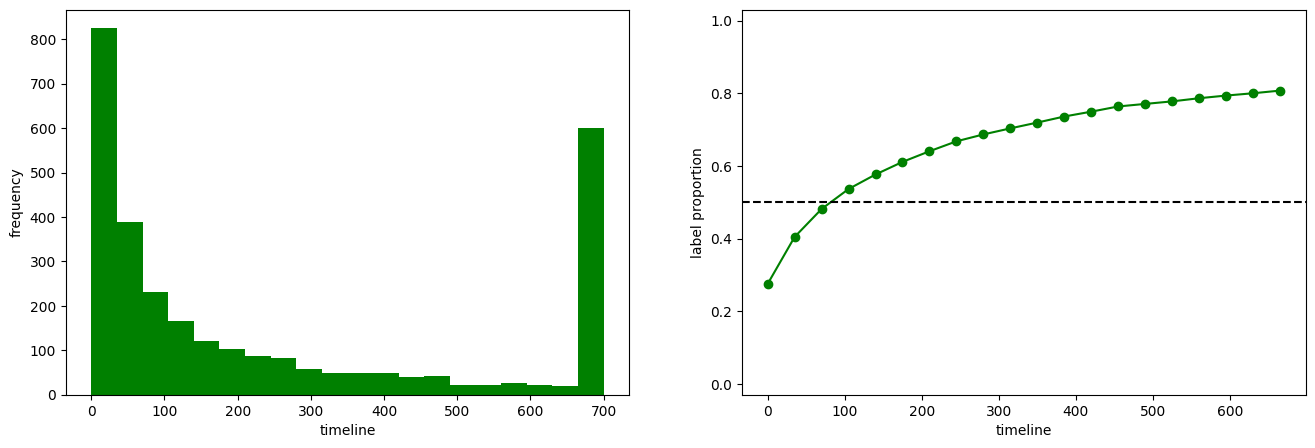

In [41]:
### PLOT EVENT TARGET AND LABEL PROPORTION ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(y_time, bins=bin_edges, color='green')
plt.xlabel('timeline'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.plot(bin_edges[:-1], y_time_ohe.mean(axis=0), marker='o', color='green')
plt.ylim([-0.03,1.03]); plt.axhline(0.5, linestyle='--', c='black')
plt.xlabel('timeline'); plt.ylabel('label proportion')
plt.show()

### Modeling

We start binning the leaving time into groups of regular length (bins). For each customer under analysis, we end up having a normalized categorical target with several unique classes equal to the number of created bins. At this point, **we can transform the target with one-hot encoding, resulting in a multidimensional binary target of zeros and ones.** The ones identify in which temporal range our customers are leaving (leaving bins). As the final step, we have to replace, in the target sequences, the zeros with ones on the left before the “leaving bins”. This final step is important to provide a temporary path in the target ready to be modeled, where zeros identify the temporal ranges in which our customers are left.


Now we have all that we need in the correct format. We have a set of features and a multidimensional binary target. In other words, we simply have to solve a multidimensional binary classification task. A possibility to solve it consists in using native scikit-learn methodologies (ClassifierChain).

In [42]:
### TRAIN-TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y_time_ohe, test_size=0.25, shuffle=True, random_state=33
)

y_test = 1 - y_test

In [43]:
y_test

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [44]:
### FIT CHAIN CLASSIFIER ###

model = ClassifierChain(
    LogisticRegression(random_state=33, max_iter=2000),
    cv=5
)
model.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(max_iter=2000,
                                                  random_state=33),
                cv=5)

With a classifier chain, **we model our multioutput classification target as standalone but dependent binary classification tasks.** We say dependant since the output of the previous step is concatenated with the initial features and used as input for the next training in the chain.

After the training phase, we end with a set of dependent binary classifiers. Each of them provides a probability outcome which is a piece to build the final individual survival curves. The probabilities are for sure between 0 and 1 but there is no guarantee about the monotony constraint proper of survival functions. In other words, **the probability of survival in the first temporal bin must be higher than the ones obtained in the following temporal ranges.** To have this requirement satisfied we operate a postprocessing manipulation on the probabilities obtained by our classifier chain at customer levels.

In [46]:
### POST-PROCESSING SURVIVAL CURVE PREDICTIONS ###

isoreg = IsotonicRegression(y_min=0, y_max=1, increasing=True)
x = np.arange(0, n_bins)

proba = model.predict_proba(X_test)

proba = Parallel(n_jobs=-1, verbose=1)(
    delayed(isoreg.fit_transform)(x, p) 
    for p in proba
)
proba = 1 - np.asarray(proba)

proba.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   10.7s finished


(750, 20)

**Simply applying isotonic regressions on the final probabilities we obtain monotonic survival curves as final outputs.**



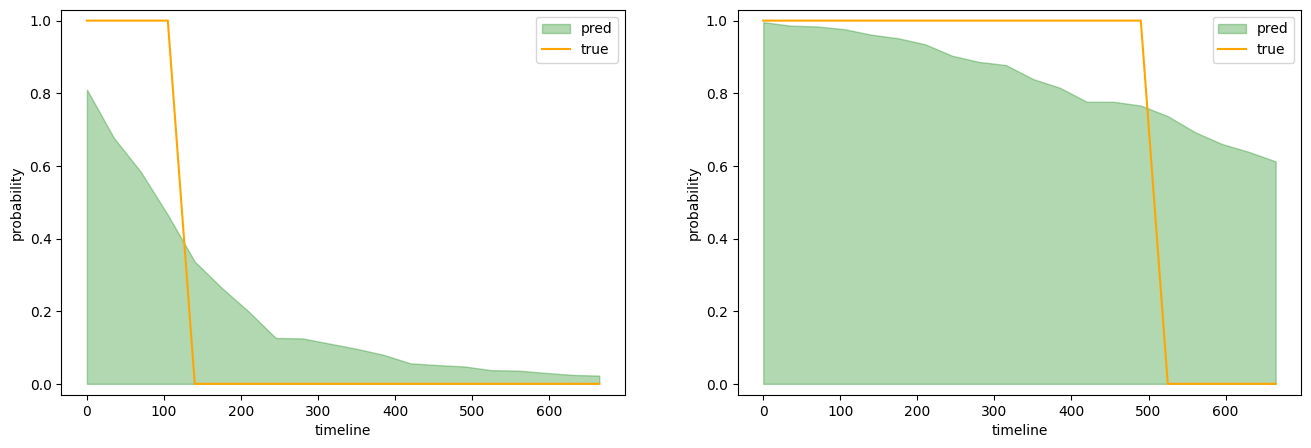

In [47]:
### PLOT PREDICTED SURVIVAL CURVES ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.fill_between(bin_edges[:-1], proba[5], color='green', alpha=0.3, label='pred')
plt.plot(bin_edges[:-1], y_test[5], color='orange', label='true')
plt.ylim([-0.03,1.03])
plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()
plt.subplot(1,2,2)
plt.fill_between(bin_edges[:-1], proba[15], color='green', alpha=0.3, label='pred')
plt.plot(bin_edges[:-1], y_test[15], color='orange', label='true')
plt.ylim([-0.03,1.03])
plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()
plt.show()

In the end, we can measure the errors like in standard supervised tasks, using our metrics of interest. We may use for example the Brier score or the more standard logistic loss.

In [48]:
### COMPUTE SCORE ON TEST DATA ###

brier_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(brier_score_loss)(true, pred, pos_label=1) 
    for true,pred in zip(y_test,proba)
)

logloss_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(log_loss)(true, pred, labels=[0,1]) 
    for true,pred in zip(y_test,proba)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.9s finished


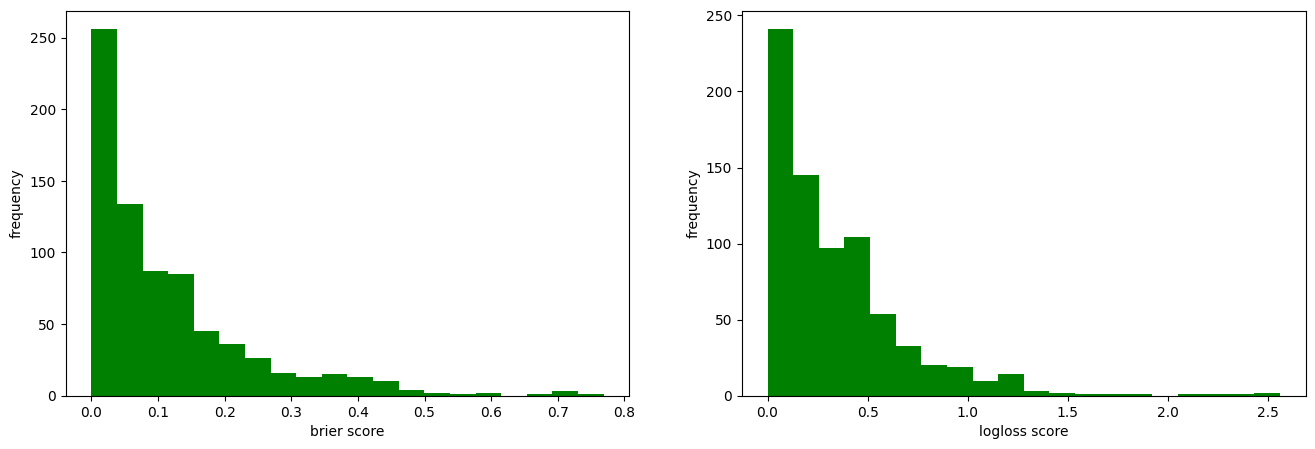

In [49]:
### PLOT TEST SCORE DISTRIBUTIONS ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(brier_scores, bins=20, color='green')
plt.xlabel('brier score'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.hist(logloss_scores, bins=20, color='green')
plt.xlabel('logloss score'); plt.ylabel('frequency')
plt.show()